In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 69 kB/s 


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

import os
import matplotlib.pyplot as plt

In [3]:
data_path = '/content/drive/MyDrive/HSE/DL/Project/data/features'

Предобработка данных

In [4]:
def encode_labels(data):
    genres = np.unique(data.label)
    d_enc = dict([(x, i) for i, x in enumerate(genres)])
    return np.array([d_enc[x] for x in data.label]), genres

def preprocess(df: pd.Series):
    # Закодируем названия жанров в числа, сохраним словарик для декодирования
    # Так же сохраним названия файлов, чтобы потом суметь отыскать несоответствия
    y, genres = encode_labels(df)
    df = df.drop('label', axis=1)
    filenames = df.filename.to_numpy()
    df = df.drop('filename', axis=1)
    X = df.to_numpy()
    return X, y, genres, filenames

Кастомный split, который делит еще и имена файлов

In [5]:
def my_train_test_split(X, y, filenames, test_size=0.2, seed=42):
    assert X.shape[0] == y.shape[0] == filenames.shape[0]
    np.random.seed = seed
    idx = np.random.permutation(X.shape[0])
    n = int(test_size * X.shape[0])

    X, y, filenames = X[idx], y[idx], filenames[idx]
    X_train, X_test = X[n:], X[:n]
    y_train, y_test = y[n:], y[:n]
    filenames_train, filenames_test = filenames[n:], filenames[:n]
    return X_train, X_test, y_train, y_test, filenames_train, filenames_test

Научимся считать метрики и строить графики
Сначала посчитаем accuracy и средние значения precision и recall. Интересно посмотреть, как выглядят метрики для разных классов. Это может дать информацию какие классы путает классификатор.

Так же учтем возможность простроения confusion matrix

In [6]:
def count_metrics(y_true, y_pred, genres, average='macro', plot=True):
    # average metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average)
    rec = recall_score(y_true, y_pred,  average=average)
    print(f'Average: acc: {acc:.3f} prec: {prec:.3f} rec: {rec:.3f}')

    # mertics per class
    multi_recall = recall_score(y_true, y_pred, average=None)
    multi_precision = precision_score(y_true, y_pred, average=None)
    print('Per class precision, recall')
    for i, (pre, re) in enumerate(zip(multi_precision, multi_recall)):
        print(f'{genres[i]:>10}:  {pre:.3f}  {re:.3f}')
    
    return multi_precision, multi_recall, y_true, y_pred
    # make plots
    # if plot:
    #     _, ax1 = plt.subplots()
    #     plot_metric(ax1, multi_recall, genres, label='recall')
    #     _, ax2 = plt.subplots()
    #     plot_metric(ax2, multi_precision, genres, label='precision')
    #     cm = confusion_matrix(y_true, y_pred)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
    #     disp.plot()
    #     plt.show()


def plot_metric(ax, metric_array, genres, label):
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
    ax.bar(genres, metric_array, 0.35)
    plt.ylim(min(metric_array)-0.05)
    ax.set_ylabel(label)
    ax.set_title(f'multi {label}')
    # ax.legend()


Наши датасеты - csv файлы со статистическими данными для музыкальных композиций

In [10]:
df_30 = pd.read_csv(os.path.join(data_path, 'features_30_sec.csv'))
df_3 = pd.read_csv(os.path.join(data_path, 'features_3_sec.csv'))

# Классификация 30 секундных файлов

In [11]:
X, y, genres, filenames = preprocess(df_30)
seed=42

Жанры:

In [12]:
list(genres)

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

# ПРОТЕСТИРУЕМ BASELINE МОДЕЛИ

## SVM

In [13]:
model = SVC(C=15, random_state=seed, kernel='rbf', degree=5)

Обучим модель и посмотрим на метрики и confusion matrix

In [14]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.675 prec: 0.675 rec: 0.678
Per class precision, recall
     blues:  0.778  0.778
 classical:  0.840  0.913
   country:  0.714  0.682
     disco:  0.579  0.524
    hiphop:  0.792  0.655
      jazz:  0.875  0.824
     metal:  0.750  0.667
       pop:  0.526  0.769
    reggae:  0.500  0.524
      rock:  0.400  0.444


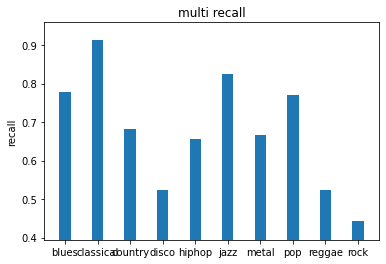

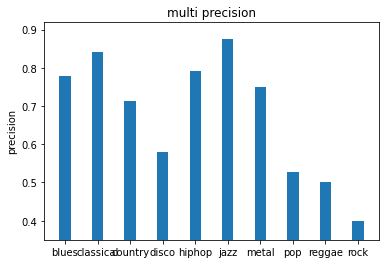

In [15]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

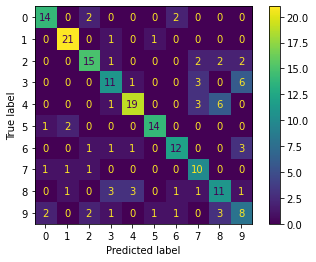

In [16]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None

### Джаз, который определяется как классическая музыка

In [18]:
idx_5_1 = (y_test == 5) & (y_test_pred == 1)
print(filenames_test[idx_5_1])
print(model.predict(scaler2.transform(X_test[idx_5_1])))

['jazz.00004.wav' 'jazz.00014.wav']
[1 1]


In [19]:
print(filenames_test[(y_test == 1) & (y_test_pred == 1)])

['classical.00016.wav' 'classical.00057.wav' 'classical.00097.wav'
 'classical.00069.wav' 'classical.00050.wav' 'classical.00022.wav'
 'classical.00000.wav' 'classical.00013.wav' 'classical.00026.wav'
 'classical.00072.wav' 'classical.00074.wav' 'classical.00008.wav'
 'classical.00031.wav' 'classical.00034.wav' 'classical.00094.wav'
 'classical.00036.wav' 'classical.00096.wav' 'classical.00024.wav'
 'classical.00021.wav' 'classical.00082.wav' 'classical.00020.wav']


### Диско и РОк
Видно, что несколько композиций в стиле Диско классификатор отнес к классу Рок. Можно найти эти файлы (и в дальнейшем послушать)

In [21]:
idx_3_9 = (y_test == 3) & (y_test_pred == 9)
print(filenames_test[idx_3_9])
print(model.predict(scaler2.transform(X_test[idx_3_9])))

['disco.00075.wav' 'disco.00014.wav' 'disco.00098.wav' 'disco.00006.wav'
 'disco.00099.wav' 'disco.00057.wav']
[9 9 9 9 9 9]


Диско, которое определяется как диско

In [22]:
print(filenames_test[(y_test == 3) & (y_test_pred == 3)])

['disco.00017.wav' 'disco.00022.wav' 'disco.00093.wav' 'disco.00009.wav'
 'disco.00078.wav' 'disco.00074.wav' 'disco.00001.wav' 'disco.00083.wav'
 'disco.00033.wav' 'disco.00067.wav' 'disco.00095.wav']


Рок, определяющийся как рок

In [32]:
print(filenames_test[(y_test == 9) & (y_test_pred == 9)])

['rock.00025.wav' 'rock.00012.wav' 'rock.00027.wav' 'rock.00097.wav'
 'rock.00082.wav' 'rock.00089.wav' 'rock.00058.wav' 'rock.00092.wav']


### Регги и Хип-хоп

Композиции в стиле Регги (8 лейбл) были отнесены к классу Хип-хоп (4 лебл). Тоже с легкостью найдем их 

In [24]:
idx_8_4 = (y_test == 8) & (y_test_pred == 4)
print(filenames_test[idx_8_4])
print(model.predict(scaler2.transform(X_test[idx_8_4])))

['reggae.00065.wav' 'reggae.00064.wav' 'reggae.00050.wav']
[4 4 4]


Хип-хоп, определяющийся как регги

In [31]:
idx_4_8 = (y_test == 4) & (y_test_pred == 8)
print(filenames_test[idx_4_8])

['hiphop.00032.wav' 'hiphop.00094.wav' 'hiphop.00002.wav'
 'hiphop.00058.wav' 'hiphop.00081.wav' 'hiphop.00080.wav']


### Кантри и Рок

Кантри, который определяется как рок

In [26]:
print(filenames_test[(y_test == 2) & (y_test_pred == 9)])

['country.00039.wav' 'country.00027.wav']


Рок, который определяется как кантри

In [33]:
print(filenames_test[(y_test == 9) & (y_test_pred == 2)])

['rock.00033.wav' 'rock.00048.wav']


## kNN

In [ ]:
model = KNeighborsClassifier(n_neighbors=2, weights="distance")

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.730 prec: 0.740 rec: 0.733
Per class precision, recall
     blues:  0.800  0.762
 classical:  0.895  0.944
   country:  0.435  0.714
     disco:  0.619  0.684
    hiphop:  0.667  0.769
      jazz:  0.864  0.731
     metal:  0.938  0.625
       pop:  0.900  0.783
    reggae:  0.667  0.625
      rock:  0.621  0.692


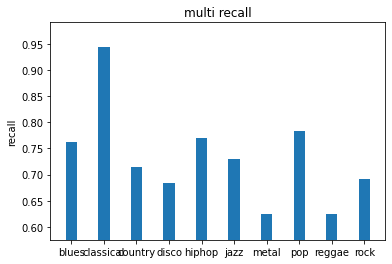

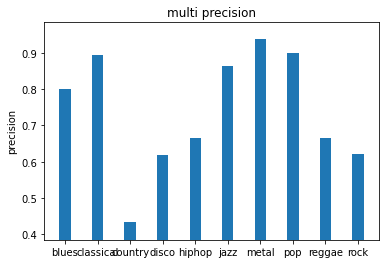

In [ ]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

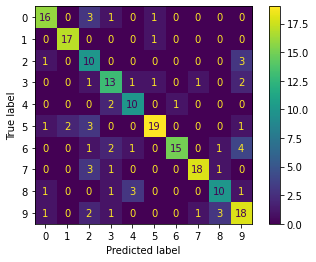

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None

## CatBoost

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    loss_function='MultiClass',
    l2_leaf_reg=0.01
)

In [ ]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test\
        = my_train_test_split(X, y, filenames, test_size=0.2, seed=seed)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
X_train_norm = scaler1.fit_transform(X_train)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(scaler2.fit_transform(X_test))
multi_precision, multi_recall, y_true, y_pred = count_metrics(y_test, y_test_pred, genres)

Average: acc: 0.825 prec: 0.825 rec: 0.822
Per class precision, recall
     blues:  0.750  0.882
 classical:  0.920  0.958
   country:  0.846  0.550
     disco:  0.875  0.778
    hiphop:  1.000  0.786
      jazz:  0.875  0.875
     metal:  0.941  0.889
       pop:  0.818  1.000
    reggae:  0.750  0.789
      rock:  0.476  0.714


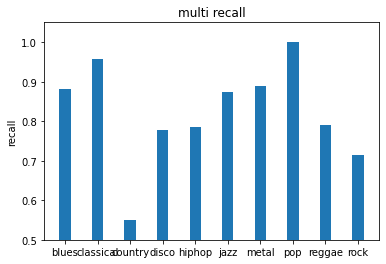

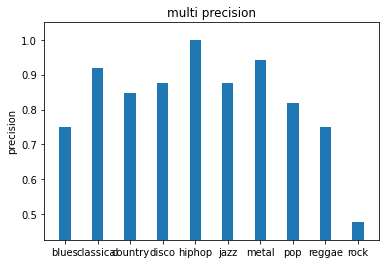

In [ ]:
_, ax1 = plt.subplots()
plot_metric(ax1, multi_recall, genres, label='recall')
_, ax2 = plt.subplots()
plot_metric(ax2, multi_precision, genres, label='precision')
plt.show()

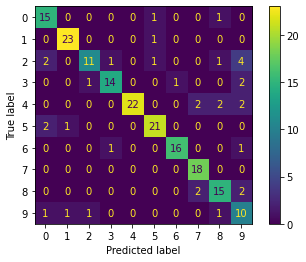

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # display_labels=genres
disp.plot()
None